In [1]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp
import jax.numpy.linalg as JLA

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange
from functools import partial

In [2]:
n = 8
num_itr = 40
K = 50
max_inner = 40
train_depth = 10
adam_lr = 0.1

In [3]:
A = np.random.randn(n,n)
A = A.T @ A
A = A/LA.norm(A)
eig, _ = LA.eig(np.eye(len(A)) - A)
lambda_min = min(eig)
lambda_max = max(eig)
omega_opt = 2/(lambda_min + lambda_max)

In [4]:
A = jnp.array(A)
@jax.jit
def gen_x_fixed(b):
    return JLA.inv((np.eye(len(A)) - A)) @ b
batch_gen_x_fixed = jax.vmap(gen_x_fixed, in_axes=-1, out_axes=-1)

In [5]:
@jax.jit
def get_dot(x):
    return x @ x.T
batch_get_dot = jax.vmap(get_dot, in_axes=-1, out_axes=-1)

In [6]:
@partial(jax.jit, static_argnums=0)
def fixed_point_itr(max_itr, b):
    x = jnp.zeros((n, K))
    for _ in range(max_itr):
        x = A@x + b
    return x        

In [7]:
@partial(jax.jit, static_argnums=0)
def SOR_itr(max_itr, b):
    x = jnp.zeros((n, K))
    for _ in range(max_itr):
        x += omega_opt * (A@x + b - x)
    return x

In [8]:
def comp_mse(max_itr, func):
    se = 0.0
    b = jnp.array(np.random.randn(n, K))
    x_fixed = batch_gen_x_fixed(b)
    x_hat = func(max_itr, b)
    return jnp.sum(batch_get_dot(x_hat - x_fixed))/K

In [9]:
org_mes = [comp_mse(i+1, fixed_point_itr) for i in range(num_itr)]
SOR_mes = [comp_mse(i+1, SOR_itr) for i in range(num_itr)]

In [10]:
df = pd.DataFrame()
df["Iteration"] = range(num_itr)
df["Original fixed-point iteration"] = np.array(org_mes)
df["SOR Iteration"] = np.array(SOR_mes)

In [11]:
@partial(jax.jit, static_argnums=1)
def DU_PSOR(b, max_itr, omega, T):
    x = np.zeros((n, K))
    for i in range(max_itr):
        k = (i % T) + 1
        x += omega[k] * (A@x + b -x)
    return x

In [12]:
@partial(jax.jit, static_argnums=2)
def loss(x_fixed, b, max_itr, T, omega):
    x_hat = DU_PSOR(b, max_itr, omega, T)
    return np.sum(batch_get_dot(x_fixed - x_hat))/K

In [13]:
opt_init, opt_update, get_params = optimizers.adam(adam_lr)

@partial(jax.jit, static_argnums=2)
def step(x_fixed, b, max_itr, T, step_num, opt_state):
    value, grads = jax.value_and_grad(loss, argnums=-1)(x_fixed, b, max_itr, T, get_params(opt_state))
    new_opt_state = opt_update(step_num, grads, opt_state)
    return value, new_opt_state

def train(omega, T):
    opt_state = opt_init(omega)
    for itr in trange(train_depth, leave=False):
        for i in range(max_inner):
            b = jnp.array(np.random.randn(n, K))
            x_fixed = batch_gen_x_fixed(b)
            value, opt_state = step(x_fixed, b, itr+1, T, i, opt_state)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return get_params(opt_state)

In [14]:
def comp_mse_DUPSOR(max_itr, omega, T):
    b = jnp.array(np.random.randn(n, K))
    x_fixed = batch_gen_x_fixed(b)
    return loss(x_fixed, b, max_itr, T, omega)

In [15]:
T = 2
omega_init = np.ones(T)
omega_trained = train(omega_init, T)

  0%|          | 0/10 [00:00<?, ?it/s]

loss:0.854634165763855  

In [18]:
DUPSOR_mse = [comp_mse_DUPSOR(i+1, omega_trained, T) for i in range(num_itr)]
df["DU-PSOR iteration T={}".format(T)] = np.array(DUPSOR_mse)

In [19]:
def abs_beta(lam, omega, T):
    prod = 1.
    for i in range(T):
        prod *= 1 - omega[i] * lam
    return abs(prod)

In [20]:
eig, _ = LA.eig(np.eye(len(A))-A)
q = []
for e in eig:
    q.append(abs_beta(e, omega_trained, T))
q = float(max(q)**(2/T))
df["Theory T={}".format(T)] = list(map(lambda t:q**t, range(num_itr)))

In [21]:
T = 4
omega_init = np.ones(T)
omega_trained = train(omega_init, T)

  0%|          | 0/10 [00:00<?, ?it/s]

loss:0.006495623383671045 

In [22]:
DUPSOR_mse = [comp_mse_DUPSOR(i+1, omega_trained, T) for i in range(num_itr)]
df["DU-PSOR iteration T={}".format(T)] = np.array(DUPSOR_mse)

In [23]:
q = []
for e in eig:
    q.append(abs_beta(e, omega_trained, T))
q = float(max(q)**(2/T))
df["Theory T={}".format(T)] = list(map(lambda t:q**t, range(num_itr)))

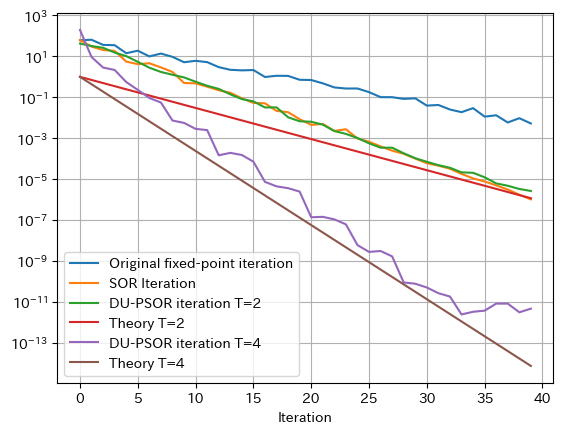

In [24]:
df.plot(df.columns[0], df.columns[1:])
plt.yscale("log")
plt.grid()